# Data Science Blog Notebook - Stack Overflow Data

In this work, I intend to take a closer look on the relation between a developer's profile and his/her income, as well as what characteristics people think could provide them with a better financial response from the market. 

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_d = pd.read_csv('../Data_Science_Post/survey_results_public.csv')
df_q = pd.read_csv('../Data_Science_Post/survey_results_schema.csv')
df_d.set_index('Respondent',inplace=True)
df_q.set_index('Column',inplace=True)


### Functions

Since I ran into an error trying to import a python file with de functions I would use for the analysis, I had to work around it by defining the needed functions on this section:

In [4]:
def des_var(ind_var,dep_var):
    '''
    INPUT:
    ind_var - list with dependent variables of interest
    dep_var - list with independent variables of interest
    
    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    
    print('Independent Variables\n')
    for entry in ind_var:
        text = df_q.loc[entry]
        pd.options.display.max_colwidth = len(text)
        print(f'{entry}: {text[0]}')    
    print('\n-----------------------------------------------------\n')
    print('Dependent Variables\n')
    for entry in dep_var:
        text = df_q.loc[entry]
        pd.options.display.max_colwidth = len(text)
        print(f'{entry}: {text[0]}')

In [3]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue

#     df_non_cat = df[list(set(df.columns)-set(cat_cols))]
#     dummies = pd.get_dummies(df[list(cat_cols)], drop_first = True, dummy_na=dummy_na)
#     df = pd.concat([df_non_cat,dummies],axis = 1)
    
    
    return df

In [4]:
def find_optimal_lm_mod(X, y, cutoffs, test_size=.30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        # reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        # split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

        # fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        # append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    # reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

    # fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [5]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#### CRISP-DM: Business Understanding

Thinking about the types of questions that could shine a light on the developer career for a new professional.

### Ideas:

1. How well analytical and methodical thinkers do financially as developers?
2. Do satisfaction levels relates to the idea of being well paid?
3. Do people who value a high level of security in a job feel that way because they are being better paid?

#### CRISP-DM: Data Understanding

Looking at the data and what it means in order to get a better grasp on how to answer the proposed questions.

Target variables used for the analysis:

In [1]:
X_var = ['ProblemSolving','BoringDetails','JobSecurity','Overpaid','DifficultCommunication','HighestEducationParents','Country','SeriousWork','RightWrongWay','EnjoyDebugging',] #Independent Variables
y_var = ['CareerSatisfaction','JobSatisfaction','Salary',]

In [5]:
# This cell is here just to help me keep track of the variables I would work throughout the assignment.

q1_X = ['BoringDetails','ProblemSolving','EnjoyDebugging','RightWrongWay']
q1_y = ['Salary']
q2_X = ['JobSatisfaction','CareerSatisfaction']
q2_y = ['Overpaid']
q3_X = ['JobSecurity']
q3_y_1 = ['Salary']
q3_y_2 = ['Overpaid']

des_var(q3_X,q3_y_1)

Independent Variables

JobSecurity: Job security is important to me

-----------------------------------------------------

Dependent Variables

Salary: What is your current annual base salary, before taxes, and excluding bonuses, grants, or other compensation?


### 1st Question: How well analytical and methodical developers do financially?

#### CRISP-DM: Prepare Data

Obtaining, preparing and formatting the data to be able to answer the proposed questions.

In [8]:
# Creating the base dataframe:
q1 = set(q1_X)|set(q1_y)
df1 = df_d[q1]

In [9]:
# Dropping columns where all the values are null:
df1_no_nan = df1.dropna(axis=0,how='all')

In [10]:
# Dropping columns where the salary is not provided:
sal_no_nan = df1_no_nan.dropna(subset=['Salary'],axis=0)

In [11]:
# Most relevant independent variables: "BoringDetails" and "EnjoyDebugging" (Must be dropped if NaN):
rel_var = ['BoringDetails','EnjoyDebugging']

In [12]:
# Dropping rows where relevant ind. variables are NaN:
data_q1 = sal_no_nan.dropna(subset=rel_var,axis=0,how='any')

In [13]:
# Check of how many NaN entries are in the remaining dependent variables "ProblemSolving" and "RightWrongWay"
print(data_q1['ProblemSolving'].isnull().sum(),data_q1['RightWrongWay'].isnull().sum(),sep=',')

11,25


Since the entire database is comprised of 5844 values, I will assume that dropping between 25 to 36 values does not result in a considerable loss in the analysis:

In [14]:
# Droping NaN values from "ProblemSolving" ad "RightWrongWay":
df_q1 = data_q1.dropna(subset=['ProblemSolving','RightWrongWay'],axis=0,how='any')

With that, the database has been cleared of NaN entries.

#### CRISP-DM: Data Modelling

Creation of a data model in order to extract the results.

In [15]:
# Creating the dummy columns:
df1_dummy = create_dummy_df(df_q1,q1_X,False)

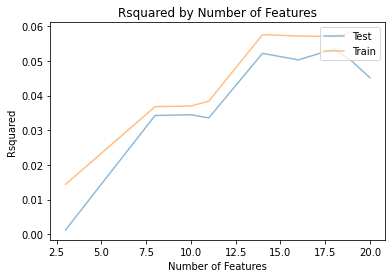

In [16]:
# Setting the dependent and independent input dataframes for the Linear Regression models:
X1 = df1_dummy.drop(labels=['Salary'],axis=1)
y1 = df1_dummy['Salary']

# Obtaining the optimal linear model:
cutoffs = [2000, 1500,1250,1000,750,500,250, 100, 50,40,30,20,10,5,0]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X1, y1, cutoffs)


In [17]:
# Using the best values for Number of Features in order to maximize the R2 value (Check):
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
print(r2_score(y_test,y_test_preds),r2_score(y_train,y_train_preds))

0.05339094380285536 0.056994415833989565


#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [18]:
# Function to weight the coefficient's influence:
coef_df = coef_weights(lm_model.coef_, X_train)

# Showing results:
coef_df

,est_int,coefs,abs_coefs
3,BoringDetails_Strongly agree,-1.517305e+17,1.517305e+17
0,BoringDetails_Agree,-1.517305e+17,1.517305e+17
2,BoringDetails_Somewhat agree,-1.517305e+17,1.517305e+17
1,BoringDetails_Disagree,-1.517305e+17,1.517305e+17
4,BoringDetails_Strongly disagree,-1.517305e+17,1.517305e+17
12,EnjoyDebugging_Strongly disagree,-1.320976e+17,1.320976e+17
8,EnjoyDebugging_Agree,-1.320976e+17,1.320976e+17
10,EnjoyDebugging_Somewhat agree,-1.320976e+17,1.320976e+17
11,EnjoyDebugging_Strongly agree,-1.320976e+17,1.320976e+17
9,EnjoyDebugging_Disagree,-1.320976e+17,1.320976e+17


Looking at the weights of the independent variables of this linear regression, we cannot assume a direct correlation between one's salary and whole of the characteristics described by them.

Therefore, in order to obtain some clarification, we shall look at the most notable variables individually: "Attention to Details" and the "Pleasure in Debugging":

#### CRISP-DM: Prepare Data

Since the last results were not optimal, we had to go back some steps in the CRISP-DM process. Therefore another round of data preparation is needed.

In [ ]:
# BoringDetails:
df1_sal_BD = sal_no_nan[['Salary','BoringDetails']]

#Filling missing values with the mode:
df1_sal_BD['BoringDetails'].fillna(df1_sal_BD['BoringDetails'].mode()[0],inplace=True)

#### CRISP-DM: Data Modelling

Creation of a data model in order to extract the results.

In [38]:
# Separating the data in order to get the influence of variables
sal_BD = df1_sal_BD.groupby('BoringDetails').mean().sort_values('Salary')

#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [40]:
# Plotting table
sal_BD

,Salary
BoringDetails,
Strongly agree,50547.118729
Agree,52131.973683
Somewhat agree,53711.731087
Disagree,57399.809663
Strongly disagree,62663.088637


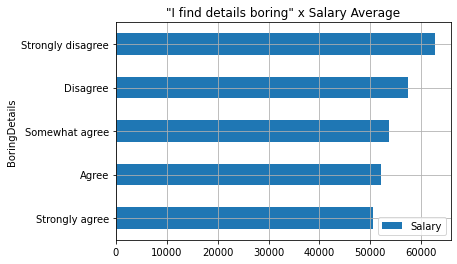

In [20]:
# Plotting a bar plot for better visualization:
(sal_BD).plot(kind="barh",grid=True);
plt.title('"I find details boring" x Salary Average');

The results show that developers who are not bothered by details tend to earn bigger salaries.

#### CRISP-DM: Prepare Data

Since the last results were not optimal, we had to go back some steps in the CRISP-DM process. Therefore another round of data preparation is needed.

In [ ]:
# EnjoyDebugging:
df1_sal_ED = sal_no_nan[['Salary','EnjoyDebugging']]
#Filling missing values with the mode
df1_sal_ED['EnjoyDebugging'].fillna(df1_sal_ED['EnjoyDebugging'].mode()[0],inplace=True)

#### CRISP-DM: Data Modelling

Creation of a data model in order to extract the results.

In [ ]:
# Separating the data in order to get the influence of variables
sal_ED = df1_sal_ED.groupby('EnjoyDebugging').mean().sort_values(by='Salary')
new_index = ['Strongly agree','Agree','Somewhat agree','Disagree','Strongly disagree']
sal_ED_correct = sal_ED.reindex(new_index)

#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [47]:
sal_ED_correct

,Salary
EnjoyDebugging,
Strongly agree,55588.764535
Agree,55722.431402
Somewhat agree,58839.165416
Disagree,56045.525162
Strongly disagree,46925.349515


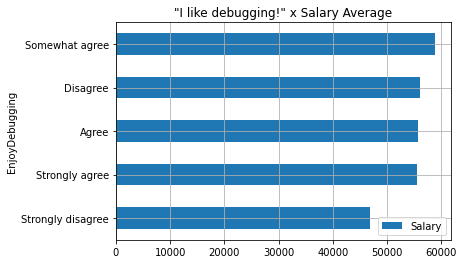

In [22]:
# Plotting a bar plot for better visualization:
(sal_ED).plot(kind="barh",grid=True);
plt.title('"I like debugging!" x Salary Average');

The tendency to enjoy debugging does not seem to hurt one's salary, although the same cannot be said for people who have a strong deslike for it.

### 2nd Question: Do satisfaction levels relates to the idea of being well paid?

#### CRISP-DM: Prepare Data

Obtaining, preparing and formatting the data to be able to answer the proposed questions.

In [ ]:
# Creating the base dataframe:
q2 = set(q2_X)|set(q2_y)
df2 = df_d[q2]

# Removing rows without information:
df2.dropna(how='all',axis=0)

In [24]:
# Removing NaN values from the "Overpaid" column:
df2.dropna(subset=['Overpaid'],axis=0)

,Overpaid,CareerSatisfaction,JobSatisfaction
Respondent,,,
3,Neither underpaid nor overpaid,8.0,9.0
9,Neither underpaid nor overpaid,6.0,6.0
15,Somewhat underpaid,8.0,8.0
18,Neither underpaid nor overpaid,9.0,8.0
19,Somewhat overpaid,5.0,3.0
...,...,...,...
51372,Neither underpaid nor overpaid,7.0,7.0
51379,Neither underpaid nor overpaid,10.0,10.0
51383,Somewhat underpaid,9.0,5.0


#### CRISP-DM: Data Modeling

Creation of a data model in order to extract the results.

In [48]:
# Checking the influence of the subcategories of "Overpaid" over "CareerSatisfaction":
OP_CS = df2[['Overpaid','CareerSatisfaction']].groupby('Overpaid').mean().sort_values(by='CareerSatisfaction')

#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [49]:
OP_CS

,CareerSatisfaction
Overpaid,
Greatly underpaid,6.744366
Somewhat underpaid,7.353803
Greatly overpaid,7.610000
Somewhat overpaid,7.762615
Neither underpaid nor overpaid,7.845181


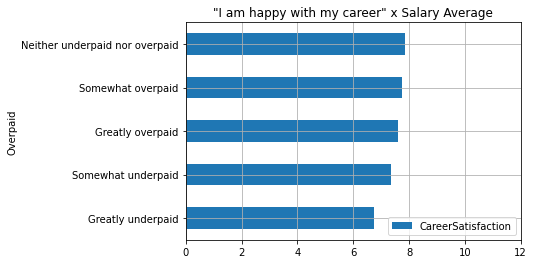

In [50]:
(OP_CS).plot.barh(xlim=(0,12),legend=True,grid=True);
plt.title('"I am happy with my career" x Salary Average');

It seems that there is a direct link between the feeling of being overpaid and the satisfaction one's career brings.

#### CRISP-DM: Data Modeling

Creation of a data model in order to extract the results.

In [51]:
# Checking the influence of the subcategories of "Overpaid" over "JobSatisfaction":
OP_JS = df2[['Overpaid','JobSatisfaction']].groupby('Overpaid').mean().sort_values(by='JobSatisfaction')

#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [44]:
OP_JS

,JobSatisfaction
Overpaid,
Greatly underpaid,5.623067
Somewhat underpaid,6.776927
Greatly overpaid,6.950000
Somewhat overpaid,7.320690
Neither underpaid nor overpaid,7.515038


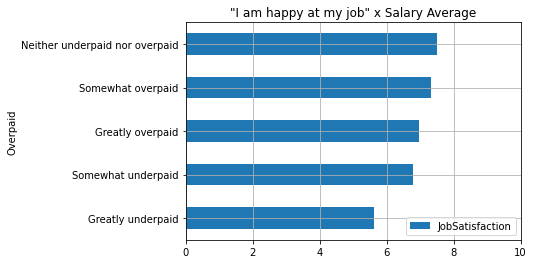

In [28]:
(OP_JS).plot.barh(xlim=(0,10),legend=True,grid=True);
plt.title('"I am happy at my job" x Salary Average');

The only conclusion we can draw from these results is that the satisfaction one feels doing a job is greatly harmed by the feeling of being underpaid, since the options "Greatly underpaid" and "Somewhat underpaid" were the ones that returned the lowest values for Job Satisfaction.

### 3rd Question: Do people who value a high level of job security feel that way because they are being better paid?

#### CRISP-DM: Prepare Data

Obtaining, preparing and formatting the data to be able to answer the proposed questions.

In [29]:
# Creating the base dataframe:
q3_X = ['JobSecurity']
q3_y_1 = ['Salary']
q3_y_2 = ['Overpaid']

q3_1 = set(q3_X)|set(q3_y_1)|set(q3_y_2)
df3 = df_d[q3_1]

Checking what people define as overpaid x underpaid (explored out of curiosity):

In [30]:
# Removing NaN values for both Salary and Overpaid columns:
df3_nona_sal_op = df3.dropna(subset=['Salary','Overpaid'],axis=0)

# Removing outliers on the set that includes people who think they are "greatly overpaid" and that makes less than 12000
# dollars per year (1000 USD per month)
clean_df = df3_nona_sal_op[df3_nona_sal_op['Overpaid']=='Greatly overpaid'][df3_nona_sal_op['Salary']<12000]
drop_list = clean_df.index
df3_nona_sal_op.drop(index=drop_list,inplace=True)


C:\Users\pc\AppData\Local\Temp/ipykernel_19148/3257047924.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = df3_nona_sal_op[df3_nona_sal_op['Overpaid']=='Greatly overpaid'][df3_nona_sal_op['Salary']<12000]
c:\python\udemycorrection\venv\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
# Since our target is Job Security, and this variable is an opinion, we'll remove the NaN values due to the subjectivity
# of this variable.
df3_final = df3_nona_sal_op.dropna(subset=['JobSecurity'],axis=0)


First, we will check the avarage values that define what the subjects in the sample think about their income, that is,
the relation between salary and the feeling of being overpaid.

In [32]:
df3_final[['Overpaid','Salary']].groupby('Overpaid').mean().sort_values(by='Salary')

,Salary
Overpaid,
Greatly underpaid,37050.917798
Somewhat underpaid,54324.142076
Neither underpaid nor overpaid,63045.899606
Somewhat overpaid,72510.748482
Greatly overpaid,74477.185417


Next, we will do the same check for the variables Salary and JobSecurity (also done out of curiosity).

In [33]:
JS_sal = df3_final[['JobSecurity','Salary']].groupby('JobSecurity').mean().sort_values(by='Salary')
JS_sal

,Salary
JobSecurity,
Strongly disagree,54581.724321
Somewhat agree,55841.216863
Agree,56489.385971
Strongly agree,57929.232909
Disagree,58325.922381


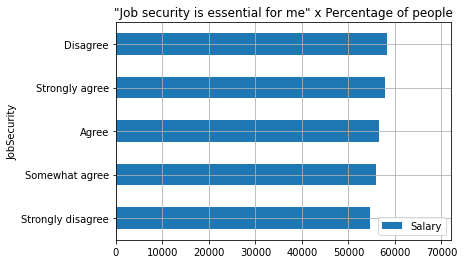

In [34]:
(JS_sal).plot.barh(grid=True,xlim=(0,72000));
plt.title('"Job security is essential for me" x Percentage of people');

The salary avarage differences are negligible between the subcategories of in "JobSecurity".

#### CRISP-DM: Data Modeling

Creation of a data model in order to extract the results.

In [52]:
# Creating dummies in order to analyze the weight of "Overpaid" on "JobSecurity":
df3_JS_OP = create_dummy_df(df3_final[['JobSecurity','Overpaid']], ['Overpaid'], dummy_na=False)
q3_out = df3_JS_OP.groupby('JobSecurity').sum()

# Transforming the sums into percentages of the subsets in "Overpaid":
col_perc = lambda col:(col/col.sum())*100
q3_perc=q3_out.apply(col_perc)

# Rearranging the index for easier analysis:
set_index = ['Strongly agree','Agree','Somewhat agree','Disagree','Strongly disagree']
q3_plot = q3_perc.reindex(set_index)
# Renaming the columns:
q3_plot.rename(columns={'Overpaid_Greatly overpaid':'Greatly overpaid', 'Overpaid_Greatly underpaid':'Greatly underpaid',
       'Overpaid_Neither underpaid nor overpaid':'Neither underpaid nor overpaid', 'Overpaid_Somewhat overpaid':'Somewhat overpaid',
       'Overpaid_Somewhat underpaid':'Somewhat underpaid'},inplace=True)
# Rounding the percentages:
q3_final = q3_plot.round(2)


#### CRISP-DM: Evaluate the Results

Having the results in hand, we are able evaluate the results and extract conclusions from them.

In [53]:
q3_final

,Greatly overpaid,Greatly underpaid,Neither underpaid nor overpaid,Somewhat overpaid,Somewhat underpaid
JobSecurity,,,,,
Strongly agree,24.0,26.96,23.14,26.20,23.57
Agree,42.0,37.16,44.33,41.44,44.26
Somewhat agree,20.0,25.49,24.93,21.92,24.00
Disagree,8.0,7.94,6.69,8.56,7.18
Strongly disagree,6.0,2.45,0.91,1.88,1.00


From these results, we can see that the percentages of people who have a determined opinion about Job Security do not vary considerably between subcategories of "Overpaid", therefore we can conclude that the feeling of having a safe job is not related to how well one thinks he/she is being paid, but is more linked to the general feeling of the population.

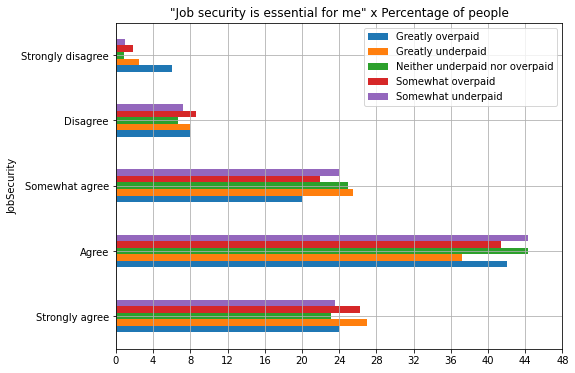

In [36]:
(q3_plot).plot.barh(xlim=(0,48),figsize=(8,6),legend=True,grid=True,xticks=range(0,49,4));
plt.title('"Job security is essential for me" x Percentage of people');